In [1]:
%reset
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigs
from scipy.integrate import cumtrapz


Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
# solves G''(z) + (N^2(z) - omega^2)G(z)/c^2 = 0 
#   subject to G'(0) = gG(0)/c^2 (free surface) & G(-D) = 0 (flat bottom)
# G(z) is normalized so that the vertical integral of (G'(z))^2 is D
# G' is dimensionless, G has dimensions of length

# - N is buoyancy frequency [s^-1] (nX1 vector)
# - depth [m] (maximum depth is considered the sea floor) (nX1 vector)
# - omega is frequency [s^-1] (scalar)
# - mmax is the highest baroclinic mode calculated
# - m=0 is the barotropic mode
# - 0 < m <= mmax are the baroclinic modes
# - Modes are calculated by expressing in finite difference form 1) the
#  governing equation for interior depths (rows 2 through n-1) and 2) the
#  boundary conditions at the surface (1st row) and the bottome (last row).
# - Solution is found by solving the eigenvalue system A*x = lambda*B*x
def vertical_modes(N2_0, Depth, omega, mmax):
    z = -1 * Depth

    if np.size(np.shape(N2_0)) > 1:
        N2 = np.nanmean(N2_0, axis=1)
    else:
        N2 = N2_0

    n = np.size(z)
    nm1 = n - 1
    nm2 = n - 2
    gravity = 9.82
    # ----- vertical increments
    dz = np.concatenate([[0], z[1:] - z[0:nm1]])  # depth increment [m]
    dzm = np.concatenate([[0], 0.5 * (z[2:] - z[0:nm2]), [0]])  # depth increment between midpoints [m]
    # ----- sparse matrices
    # A = row pos, B = col pos, C = val  
    A = np.concatenate([[0], [0], np.arange(1, nm1), np.arange(1, nm1), np.arange(1, nm1), [n - 1]])
    B = np.concatenate([[0], [1], np.arange(1, nm1), np.arange(0, nm2), np.arange(2, n), [n - 1]])
    C = np.concatenate(
        [[-1 / dz[1]], [1 / dz[1]], (1 / dz[2:] + 1 / dz[1:nm1]) / dzm[1:nm1], -1 / (dz[1:nm1] * dzm[1:nm1]),
         -1 / (dz[2:n] * dzm[1:nm1]), [-1]])
        # [[-1 / dz[1]], [1 / dz[1]], (1 / dz[2:] + 1 / dz[1:nm1]) / dzm[1:nm1], -1 / (dz[1:nm1] * dzm[1:nm1]),
        #  -1 / (dz[2:n] * dzm[1:nm1]), [-1]])
    mat1 = coo_matrix((C, (A, B)), shape=(n, n))

    D = np.concatenate([[0], np.arange(1, n)])
    E = np.concatenate([[0], np.arange(1, n)])
    F = np.concatenate([[gravity], N2[1:] - omega * omega])  # originially says N2[1:,10]
    mat2 = coo_matrix((F, (D, E)), shape=(n, n))

    # compute eigenvalues and vectors 
    vals, vecs = eigs(mat1, k=mmax + 1, M=mat2, sigma=0)
    eigenvalue = np.real(vals)
    wmodes = np.real(vecs)
    s_ind = np.argsort(eigenvalue)
    eigenvalue = eigenvalue[s_ind]
    wmodes = wmodes[:, s_ind]
    m = np.size(eigenvalue)
    c = 1 / np.sqrt(eigenvalue)  # kelvin wave speed
    # normalize mode (shapes)
    Gz = np.zeros(np.shape(wmodes))
    G = np.zeros(np.shape(wmodes))
    for i in range(m):
        dw_dz = np.nan * np.ones(np.shape(z))
        dw_dz[0] = (wmodes[1, i] - wmodes[0, i]) / (z[1] - z[0])
        dw_dz[-1] = (wmodes[-1, i] - wmodes[-2, i]) / (z[-1] - z[-2])
        for j in range(1, len(z) - 1):
            dw_dz[j] = (wmodes[j + 1, i] - wmodes[j - 1, i]) / (z[j + 1] - z[j - 1])
        # dw_dz = np.gradient(wmodes[:, i], z)
        norm_constant = np.sqrt(np.trapz((dw_dz * dw_dz), (-1 * z)) / (-1 * z[-1]))
        # norm_constant = np.abs(np.trapz(dw_dz * dw_dz, z) / Depth.max())

        if dw_dz[0] < 0:
            norm_constant = -1 * norm_constant
        Gz[:, i] = dw_dz / norm_constant

        norm_constant_G = np.sqrt(np.trapz((wmodes[:, i] * wmodes[:, i]), (-1 * z)) / (-1 * z[-1]))
        G[:, i] = wmodes[:, i] / norm_constant

    #epsilon = np.nan * np.zeros((5, 5, 5))  # barotropic and first 5 baroclinic
    #for i in range(0, 5):  # i modes
    #    for j in range(0, 5):  # j modes
    #        for m in range(0, 5):  # k modes
    #            epsilon[i, j, m] = np.trapz((Gz[:, i] * Gz[:, j] * Gz[:, m]), -1.0*z) / (-1.0*z[-1])

    return G, Gz, c#, epsilon


Computing QG modes at an individual gridbox.

In [19]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
from matplotlib.pyplot import cm
import cmocean

In [161]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
#run=20 #1/4 degree NeverWorld setup
#run=26 #1/8 degree NeverWorld setup
run=28 #1/16 degree NeverWorld setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00000500.nc' % (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400
sn     = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False) #snapshot
av     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [171]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
run=33 #1/32 degree NeverWorld setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00002000.nc' % (run), decode_times=False)
#av = xr.open_dataset('run%i/averages_00002002.nc' % (run), decode_times=False)  #5-day average

av=xr.open_mfdataset(['run33/averages_00001702.nc','run33/averages_00001802.nc', 'run33/averages_00001902.nc', 'run33/averages_00002002.nc', 'run33/averages_00002102.nc'],decode_times=False,combine='by_coords')
#print(av)
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [172]:
#Read in various grid variables from the static file and forcing:
lon=fs['geolon']; lat=fs['geolat']
depth = fs['depth_ocean']

xh = fs.xh.values
yh = fs.yh.values


taux= forcing.taux.values[0,:,:]; taux=(taux[:,1:]+taux[:,:-1])/2.
taux.shape

(4480, 1920)

In [173]:
#1/4 degree:560 lat x 240 lon 
#60,460 in 1/4 degree is nominal analysis point!
index_lon=1600; index_lat=640 #1/4 degree: (60,460), (120,160), (120,80), (200,80)

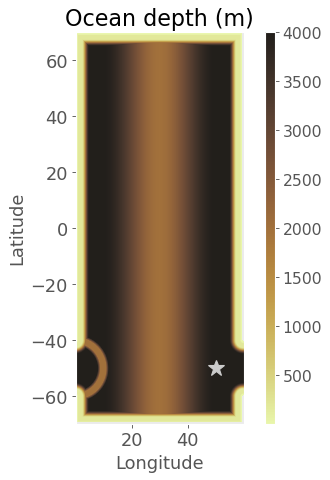

In [174]:
#Plotting ocean depth
fig = plt.figure(figsize=(4, 7), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Ocean depth (m)',fontsize=20)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

plotted =ax1.pcolor(xh,yh,depth,cmap=cmocean.cm.turbid)
ax1.plot(xh[index_lon],yh[index_lat],'*',markersize=15,color=[0.8, 0.8, 0.8])
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
#
plt.show()
#fig.savefig('topography.png')

In [175]:
Layer = np.array(os['Layer']);
Layermat=np.tile(Layer,[len(xh),1]);   Layermat=np.moveaxis(Layermat, [0, 1], [1, 0])
Interface = np.array(os['Interface']); drho=np.diff(Interface)


v = np.nanmean(np.array(av['v'][:,:,index_lat-1:index_lat+1,index_lon]),axis=2);
u = np.nanmean(np.array(av['u'][:,:,index_lat,index_lon-1:index_lon+1]),axis=2); 

h = np.array(av['h'][:,:,index_lat,index_lon]);
eta = np.zeros([100,len(Layer)+1]);

for i in range(1,len(Layer)+1):
    for j in range(0,100):
        eta[j,i]=np.nansum(h[j,0:i])    
#To make sure eta is correct: #print(eta[:,50]); print(h[:,50])    
eta=(eta[:,1:]+eta[:,:-1])/2.
drhodz=drho/h
N2=(9.81/1025.)*drhodz


N2[N2>1.e-1] =np.nan
print(v.shape,u.shape)

(100, 15) (100, 15)


In [176]:
N2.shape

(100, 15)

In [177]:
BT_KE=np.zeros(100)
BC_KE=np.zeros(100)
KE_u_t=np.zeros([100,15])
KE_v_t=np.zeros([100,15])

In [178]:
#nmodes=len(N2_filtered)-3
for i in range(0,100):
    etai=eta[i,:]; ui=u[i,:]; vi=v[i,:]; N2i=N2[i,:]
    eta_filtered = etai[~np.isnan(N2i)]
    u_filtered = ui[~np.isnan(N2i)]
    v_filtered = vi[~np.isnan(N2i)]
    N2_filtered = N2i[~np.isnan(N2i)]
    nmodes=len(N2_filtered)-3
    print(i)
    [G, Gz, c]=vertical_modes(N2_filtered, eta_filtered, 0, nmodes)
    amp_u=np.linalg.lstsq(Gz,u_filtered)[0]
    amp_v=np.linalg.lstsq(Gz,v_filtered)[0]

    BT_KE[i]=0.5*amp_u[0]**2+0.5*amp_v[0]**2
    BC_KE[i]=np.nansum(0.5*amp_u[1:]**2)+np.nansum(0.5*amp_v[1:]**2)

    KE_u_t[i,0:nmodes+1]=0.5*amp_u[:]**2 #has modes 
    KE_v_t[i,0:nmodes+1]=0.5*amp_v[:]**2


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Text(0, 0.5, 'KE')

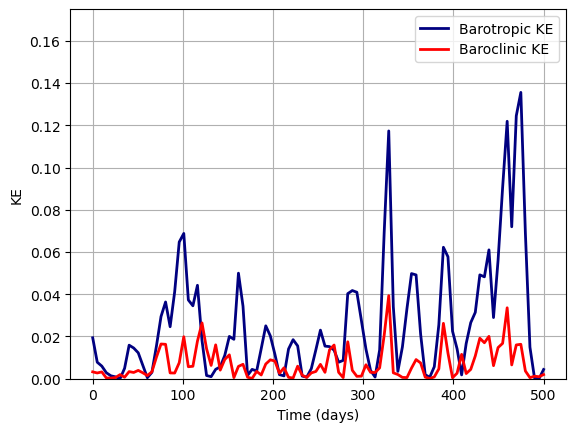

In [179]:
plt.style.use('default')
#plt.plot(u_filtered,-eta_filtered,c='c')
plt.plot(np.linspace(0,500,100),BT_KE,c=[0., 0., 0.5],linewidth=2,markersize=10)

#plt.plot(v_filtered,-eta_filtered,c=[0.7, 0.7, 0])
plt.plot(np.linspace(0,500,100),BC_KE,c=[1, 0, 0],linewidth=2,markersize=10)

plt.grid()
#plt.plot([0, 500],[0, -4000],'--',color=[0,0,0])

#plt.xlim(-.3, .3)
plt.ylim(0,0.175);
plt.xlabel('Time (days)')
plt.legend(['Barotropic KE','Baroclinic KE'])
plt.ylabel('KE')
#plt.title('%i total modes' % (nmodes+1))
#plt.show()

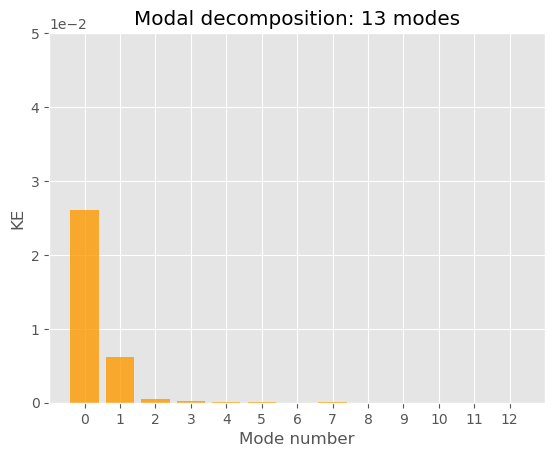

In [181]:
plt.style.use('ggplot')

nmodes=12
x = np.linspace(0,14,15)
amp1 = np.nanmean(KE_u_t+KE_v_t,axis=0)

plt.bar(x, amp1, color=[1., .6, 0.],alpha=0.8)
plt.xlabel("Mode number")
plt.ylabel("KE")
plt.title("Modal decomposition: %i modes" % (nmodes+1))
plt.ylim(0,5e-2)
plt.xlim(-1,13)
plt.xticks((0,1,2,3,4,5,6,7,8,9,10,11,12))
plt.ticklabel_format(axis="y", style="sci",scilimits=(0,0))

([<matplotlib.axis.XTick at 0x2adb87ef71d0>,
 <a list of 13 Text major ticklabel objects>)

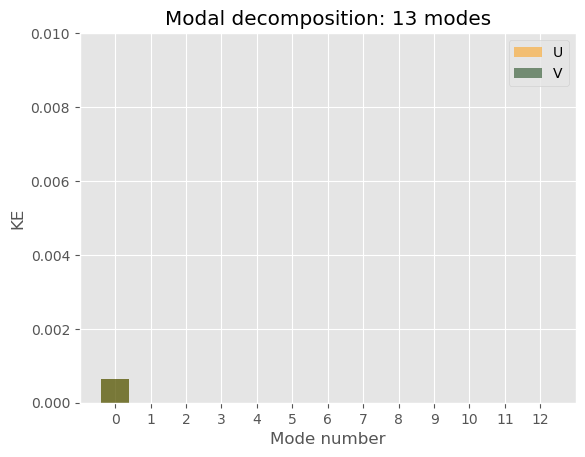

In [31]:
plt.style.use('ggplot')

nmodes=12
x = np.linspace(0,14,15)
amp1 = np.nanmean(KE_u_t,axis=0)
amp2 = np.nanmean(KE_v_t,axis=0)
#amp1 = KE_u_t[99,:]
#amp2 = KE_v_t[99,:]

plt.bar(x, amp1, color=[1., .6, 0.],alpha=0.5)
plt.bar(x, amp2, color=[0., 0.2, 0.],alpha=0.5)
plt.xlabel("Mode number")
plt.ylabel("KE")
plt.title("Modal decomposition: %i modes" % (nmodes+1))
plt.legend(['U','V'])
plt.ylim(0,1e-2)
plt.xlim(-1,13)
plt.xticks((0,1,2,3,4,5,6,7,8,9,10,11,12))